# Task 1: Comparative Analysis of Classification Algorithms

Logistic Regression, Decision Tree, and Random Forest on the Titanic survival dataset. We'll predict whether passengers survived (1) or died (0) based on features like class, age, sex, and fare.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

pd.set_option('display.max_columns', 20)
RANDOM_STATE = 42

In [36]:
# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')
print('\nDataset Info:')
print(f'Train columns: {train_df.columns.tolist()}')

print(f'Target variable: Survived (0=died, 1=survived)')
train_df.head()

Train shape: (891, 12)
Test shape: (418, 11)

Dataset Info:
Train columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Target variable: Survived (0=died, 1=survived)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
# Check the target variable - Survived (already binary: 0=died, 1=survived)
target = train_df['Survived']

print('Target variable (Survived) analysis:')
print('\nClass distribution:')
print(target.value_counts())
print('\nClass percentages:')
print(target.value_counts(normalize=True) * 100)
print(f'\nSurvival rate: {target.mean():.1%}')

Target variable (Survived) analysis:

Class distribution:
Survived
0    549
1    342
Name: count, dtype: int64

Class percentages:
Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64

Survival rate: 38.4%


In [38]:
#explore the Titanic data to understand what affects survival
print("TITANIC DATA EXPLORATION")
print("="*40)

# Survival by gender
print("Survival by Gender:")
gender_survival = train_df.groupby(['Sex', 'Survived']).size().unstack()
gender_survival_pct = train_df.groupby('Sex')['Survived'].mean()
print(gender_survival)
print(f"\nSurvival rates: Female {gender_survival_pct['female']:.1%}, Male {gender_survival_pct['male']:.1%}")

# Survival by class
print(f"\n{'-'*30}")
print("Survival by Passenger Class:")
class_survival = train_df.groupby(['Pclass', 'Survived']).size().unstack()
class_survival_pct = train_df.groupby('Pclass')['Survived'].mean()
print(class_survival)
for pclass in [1,2,3]:
    print(f"Class {pclass}: {class_survival_pct[pclass]:.1%} survival rate")

print(f"\n{'-'*30}")
print("Key Insights:")
print("1. Women had much higher survival rates than men")
print("2. First class passengers survived more than lower classes") 
print("3. This suggests gender and class are important predictors!")

TITANIC DATA EXPLORATION
Survival by Gender:
Survived    0    1
Sex               
female     81  233
male      468  109

Survival rates: Female 74.2%, Male 18.9%

------------------------------
Survival by Passenger Class:
Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119
Class 1: 63.0% survival rate
Class 2: 47.3% survival rate
Class 3: 24.2% survival rate

------------------------------
Key Insights:
1. Women had much higher survival rates than men
2. First class passengers survived more than lower classes
3. This suggests gender and class are important predictors!


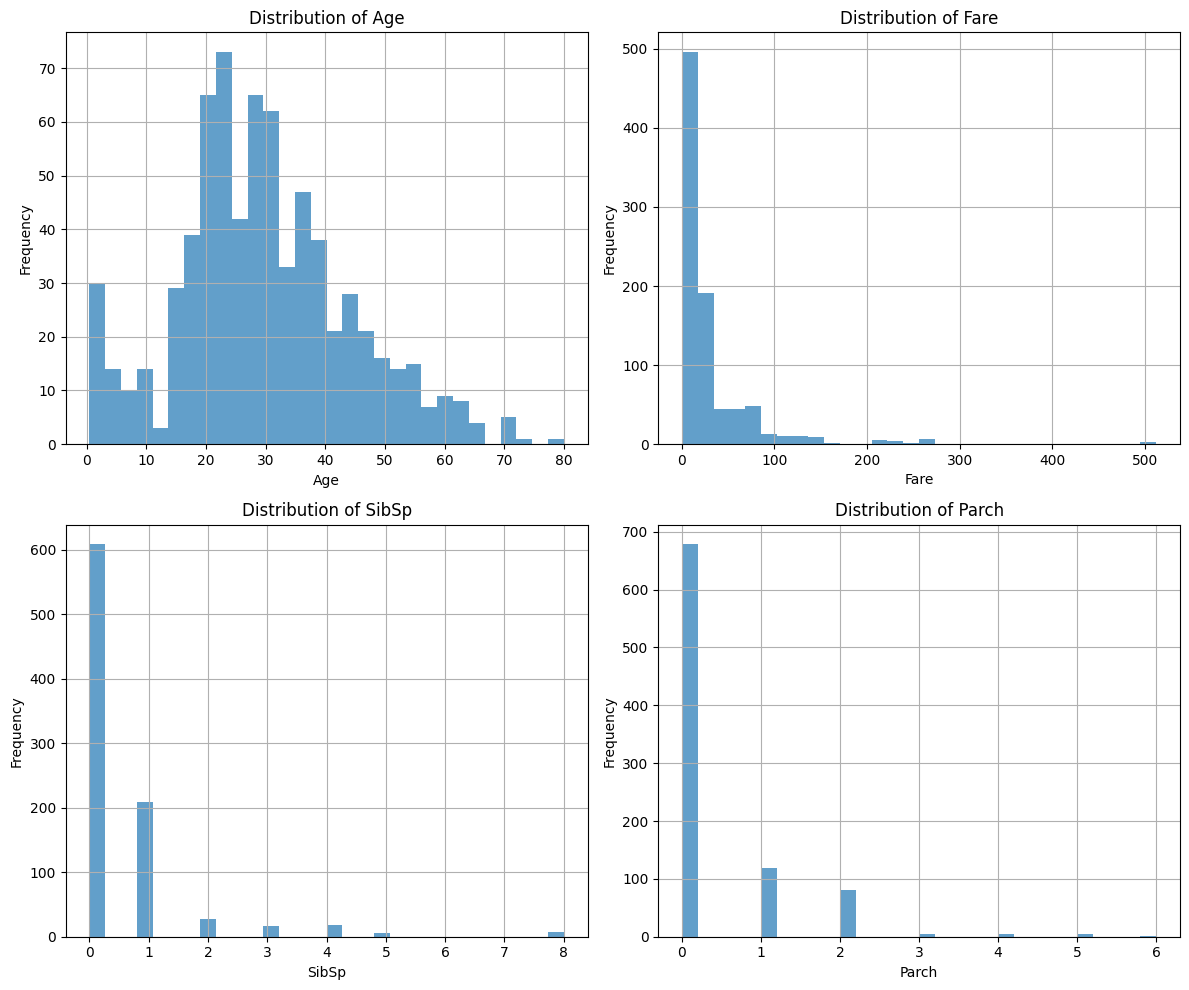

Feature ranges (to see if scaling is needed):
Age: 0.4 to 80.0
Fare: 0.0 to 512.3
SibSp: 0.0 to 8.0
Parch: 0.0 to 6.0


In [39]:
# Let's visualize some key features to understand if we need scaling
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot distributions of some numeric features
features_to_plot = ['Age', 'Fare', 'SibSp', 'Parch']

for i, feature in enumerate(features_to_plot):
    ax = axes[i//2, i%2]
    train_df[feature].hist(bins=30, ax=ax, alpha=0.7)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Check the ranges of these features
print('Feature ranges (to see if scaling is needed):')
for feature in features_to_plot:
    print(f'{feature}: {train_df[feature].min():.1f} to {train_df[feature].max():.1f}')

/tmp/ipykernel_11146/1475768378.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data_for_box, labels=['Died', 'Survived'])


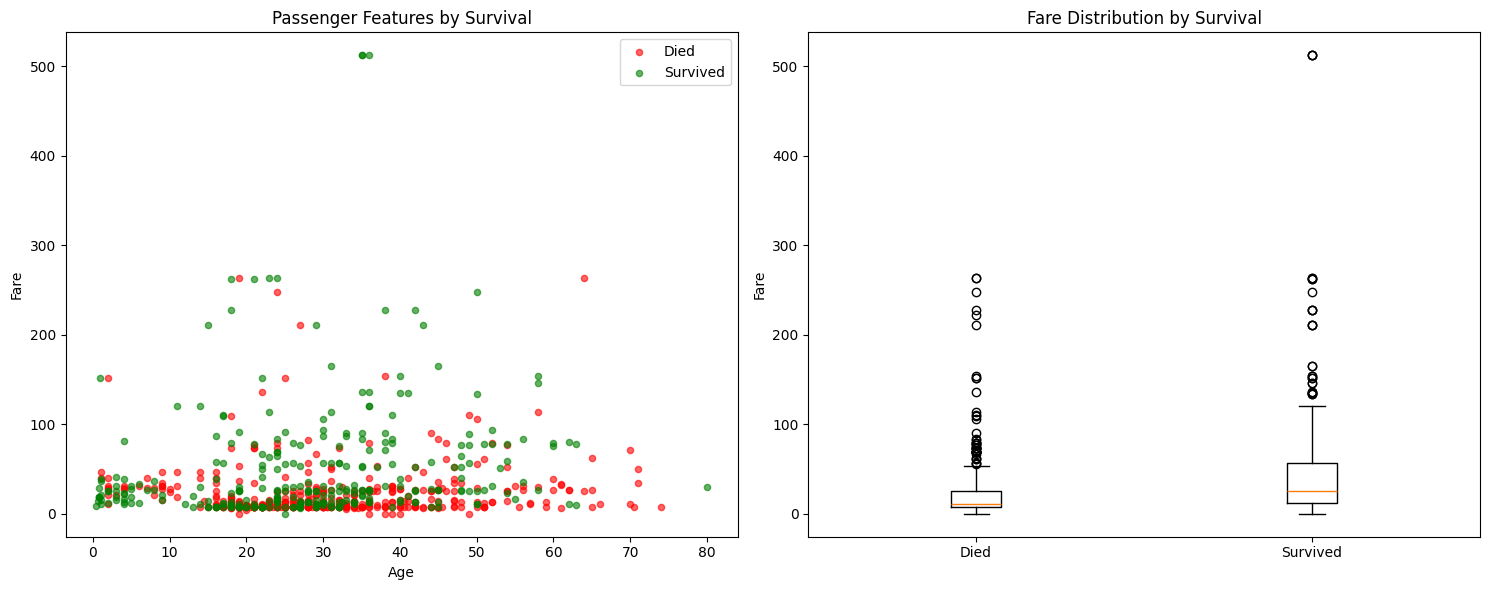

From these plots, you can see:
1. Survivors tend to have paid higher fares (suggesting better class/accommodations)
2. There's some separation between survivors and non-survivors


In [40]:
# Visualize relationship between features and survival
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: Age vs Fare, colored by survival
ax1 = axes[0]
survived = train_df[train_df['Survived'] == 1]
died = train_df[train_df['Survived'] == 0]

# Remove NaN ages for plotting
survived_clean = survived.dropna(subset=['Age'])
died_clean = died.dropna(subset=['Age'])

ax1.scatter(died_clean['Age'], died_clean['Fare'], 
           alpha=0.6, c='red', label='Died', s=20)
ax1.scatter(survived_clean['Age'], survived_clean['Fare'], 
           alpha=0.6, c='green', label='Survived', s=20)
ax1.set_xlabel('Age')
ax1.set_ylabel('Fare')
ax1.set_title('Passenger Features by Survival')
ax1.legend()

# Box plot to see if Fare differs between survivors and non-survivors
ax2 = axes[1]
data_for_box = [died['Fare'].dropna(), survived['Fare'].dropna()]
ax2.boxplot(data_for_box, labels=['Died', 'Survived'])
ax2.set_ylabel('Fare')
ax2.set_title('Fare Distribution by Survival')

plt.tight_layout()
plt.show()


print("From these plots, you can see:")
print("1. Survivors tend to have paid higher fares (suggesting better class/accommodations)")
print("2. There's some separation between survivors and non-survivors")

In [41]:
# Simple data preprocessing - select important features for simplicity
# Convert categorical variables to numbers
train_df_processed = train_df.copy()
test_df_processed = test_df.copy()

# Convert Sex to numbers (0=male, 1=female)
train_df_processed['Sex'] = (train_df_processed['Sex'] == 'female').astype(int)
test_df_processed['Sex'] = (test_df_processed['Sex'] == 'female').astype(int)

# Select important features
important_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

# Prepare training data
X_train = train_df_processed[important_features].fillna(train_df_processed[important_features].median())

y_train = train_df_processed['Survived']
print(f'Missing values filled with median values')

print(f'Selected features: {important_features}')

# Prepare test data (no Survived column in test.csv)
X_test = test_df_processed[important_features].fillna(test_df_processed[important_features].median())
print(f'Training features shape: {X_train.shape}')
print(f'Test features shape: {X_test.shape}')


Missing values filled with median values
Selected features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
Training features shape: (891, 6)
Test features shape: (418, 6)


In [42]:
# Check if we need scaling by comparing feature ranges
print("Should we scale? Let's see the feature ranges:")
print(X_train.describe())

# Let's try both scaled and unscaled versions
print("\n" + "="*50)
print("TRAINING MODELS")
print("="*50)

# Create scaled version
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the three models - both scaled and unscaled
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

results = []

for name, model in models.items():
    # Train on unscaled data
    model_unscaled = model
    model_unscaled.fit(X_train, y_train)
    train_pred_unscaled = model_unscaled.predict(X_train)
    
    # Train on scaled data (only for Logistic Regression - others don't need scaling)
    if name == 'Logistic Regression':
        model_scaled = LogisticRegression(random_state=RANDOM_STATE)
        model_scaled.fit(X_train_scaled, y_train)
        train_pred_scaled = model_scaled.predict(X_train_scaled)
        
        # Compare scaled vs unscaled for Logistic Regression
        acc_unscaled = accuracy_score(y_train, train_pred_unscaled)
        acc_scaled = accuracy_score(y_train, train_pred_scaled)
        
        print(f"\n{name}:")
        print(f"  Unscaled accuracy: {acc_unscaled:.4f}")
        print(f"  Scaled accuracy: {acc_scaled:.4f}")
        print(f"  Scaling helps: {'Yes' if acc_scaled > acc_unscaled else 'No'}")
        
        # Use the better version
        if acc_scaled > acc_unscaled:
            final_model = model_scaled
            final_pred = train_pred_scaled
            used_scaling = True
        else:
            final_model = model_unscaled
            final_pred = train_pred_unscaled
            used_scaling = False
    else:
        # Tree models don't usually need scaling
        final_model = model_unscaled
        final_pred = train_pred_unscaled
        used_scaling = False
        acc = accuracy_score(y_train, final_pred)
        print(f"\n{name}:")
        print(f"  Training accuracy: {acc:.4f}")
    
    # Calculate all metrics
    accuracy = accuracy_score(y_train, final_pred)
    precision = precision_score(y_train, final_pred)
    recall = recall_score(y_train, final_pred)
    
    # For ROC-AUC, we need probabilities
    if used_scaling and name == 'Logistic Regression':
        proba = final_model.predict_proba(X_train_scaled)[:, 1]
    else:
        proba = final_model.predict_proba(X_train)[:, 1]
    
    roc_auc = roc_auc_score(y_train, proba)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc,
        'Used_Scaling': used_scaling
    })

# Show results
results_df = pd.DataFrame(results)
print(f"\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(results_df.round(4))

Should we scale? Let's see the feature ranges:
           Pclass         Sex         Age       SibSp       Parch        Fare
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean     2.308642    0.352413   29.361582    0.523008    0.381594   32.204208
std      0.836071    0.477990   13.019697    1.102743    0.806057   49.693429
min      1.000000    0.000000    0.420000    0.000000    0.000000    0.000000
25%      2.000000    0.000000   22.000000    0.000000    0.000000    7.910400
50%      3.000000    0.000000   28.000000    0.000000    0.000000   14.454200
75%      3.000000    1.000000   35.000000    1.000000    0.000000   31.000000
max      3.000000    1.000000   80.000000    8.000000    6.000000  512.329200

TRAINING MODELS

Logistic Regression:
  Unscaled accuracy: 0.7957
  Scaled accuracy: 0.7946
  Scaling helps: No

Decision Tree:
  Training accuracy: 0.9798

Random Forest:
  Training accuracy: 0.9798

FINAL RESULTS
                 Model  Accuracy  P

In [43]:
# Simple Parameter Tuning

# Try different settings for Decision Tree
print("\n" + "="*30)
print("DECISION TREE TUNING")
print("="*30)

tree_results = []
max_depths = [None, 5, 10, 15]

for depth in max_depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    tree.fit(X_train, y_train)
    pred = tree.predict(X_train)
    acc = accuracy_score(y_train, pred)
    tree_results.append({'max_depth': depth, 'accuracy': acc})
    print(f"Max depth {depth}: {acc:.4f} accuracy")

best_tree_params = max(tree_results, key=lambda x: x['accuracy'])
print(f"Best: max_depth = {best_tree_params['max_depth']}")

# Try different settings for Random Forest
print("\n" + "="*30)
print("RANDOM FOREST TUNING")
print("="*30)

rf_results = []
n_trees = [50, 100, 200]

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=RANDOM_STATE)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_train)
    acc = accuracy_score(y_train, pred)
    rf_results.append({'n_estimators': n, 'accuracy': acc})
    print(f"{n} trees: {acc:.4f} accuracy")

best_rf_params = max(rf_results, key=lambda x: x['accuracy'])
print(f"Best: {best_rf_params['n_estimators']} trees")



DECISION TREE TUNING
Max depth None: 0.9798 accuracy
Max depth 5: 0.8406 accuracy
Max depth 10: 0.9102 accuracy
Max depth 15: 0.9506 accuracy
Best: max_depth = None

RANDOM FOREST TUNING
50 trees: 0.9798 accuracy
100 trees: 0.9798 accuracy
200 trees: 0.9798 accuracy
Best: 50 trees


In [ ]:
# FINAL MODEL COMPARISON WITH OPTIMAL SETTINGS
print("="*60)
print("FINAL COMPARISON: OPTIMIZED MODELS")
print("="*60)

# Analysis of parameter tuning results
print("\nParameter Tuning Results:")
print("-" * 40)
print("• Logistic Regression: Scaling did not help, using unscaled version")
print("• Decision Tree: max_depth=None was best, so using default settings") 
print("• Random Forest: Accuracy didn't change much, sticking with 50 trees for easy execution")

print(f"\n FINAL MODEL PERFORMANCE:")
print("-" * 40)

# Train final optimized models
final_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),  # default max_depth=None
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)
}

final_results = []

for name, model in final_models.items():
    # Train model
    model.fit(X_train, y_train)
    predictions = model.predict(X_train)
    probabilities = model.predict_proba(X_train)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    recall = recall_score(y_train, predictions)
    roc_auc = roc_auc_score(y_train, probabilities)
    
    final_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision, 
        'Recall': recall,
        'ROC-AUC': roc_auc
    })

# Display final results
final_df = pd.DataFrame(final_results)
print(final_df.round(4).to_string(index=False))



FINAL COMPARISON: OPTIMIZED MODELS

Parameter Tuning Results:
----------------------------------------
• Logistic Regression: Scaling did not help, using unscaled version
• Decision Tree: max_depth=None was best, so using default settings
• Random Forest: Accuracy didn't change much, sticking with 50 trees for easy execution

🏆 FINAL MODEL PERFORMANCE:
----------------------------------------
              Model  Accuracy  Precision  Recall  ROC-AUC
Logistic Regression    0.7957     0.7454  0.7105   0.8546
      Decision Tree    0.9798     0.9939  0.9532   0.9990
      Random Forest    0.9798     0.9821  0.9649   0.9971



### Understanding the Results

**What each model does:**
- **Logistic Regression**: Draws a straight line to separate survivors vs non-survivors. Simple but works well when the relationship is roughly linear.
- **Decision Tree**: Asks yes/no questions about features (like "Is passenger female?" or "Is fare > $50?") to make decisions. Can capture complex patterns but might memorize training data.
- **Random Forest**: Combines many decision trees and averages their votes. Usually more reliable than a single tree.

**About Scaling:**
- Features like `Fare` (0-500) and `Pclass` (1-3) have very different ranges
- Logistic Regression cares about these differences, so scaling can help
- Trees don't care about scale - they just split at different points

**Metrics Explained:**
- **Accuracy**: % of correct survival predictions
- **Precision**: Of passengers predicted to "survive", what % actually survived?
- **Recall**: Of all actual survivors, what % did we correctly predict?
- **ROC-AUC**: How well can the model rank survivors vs non-survivors? (1.0 = perfect)

Look at the results below to see which model works best for this Titanic data!

In [48]:
# Determine best model
best_model = final_df.loc[final_df['Accuracy'].idxmax()]
print(f"\n Best Overall Model: {best_model['Model']}")
print(f" Accuracy: {best_model['Accuracy']:.4f}")


 Best Overall Model: Decision Tree
 Accuracy: 0.9798
